## Семинар 2 "Распознавание рукописных цифр"

ФИО: Захватаев Михаил Дмитриевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [45]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
import torch
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
from skimage.transform import rotate
%matplotlib inline

In [59]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [60]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

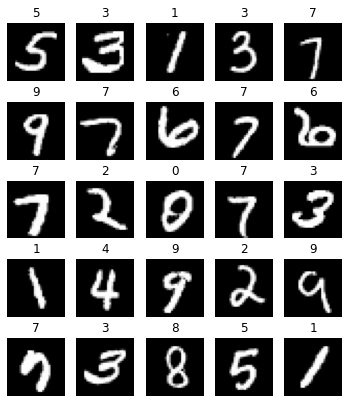

In [61]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [62]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [63]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.311/0.304	Accuracy: 0.918/0.918

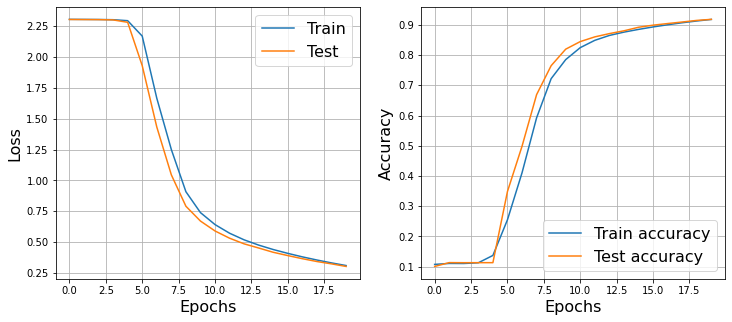

In [64]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.080	Accuracy: 0.991/0.976

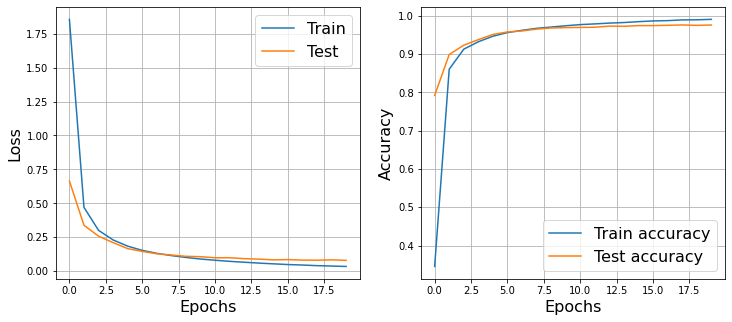

In [10]:
"""
Use ReLU as nonlinear function
"""
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.082	Accuracy: 0.986/0.973

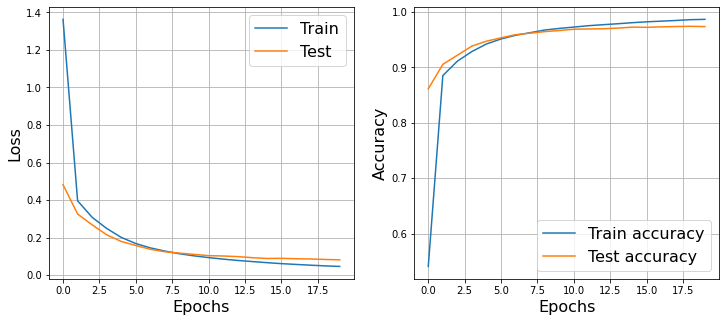

In [11]:
"""
Use ELU as nonlinear function
"""
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

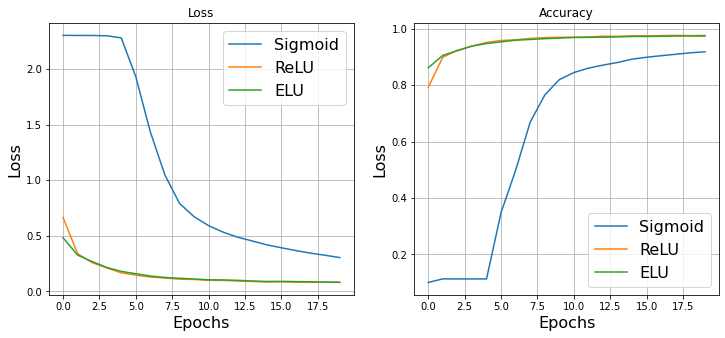

In [65]:
"""
Сравниваем скорости сходимости и качество классификации различных функций активации
"""
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

**Как видим, Сигмоида сильно уступает ReLU и ELU**

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [13]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

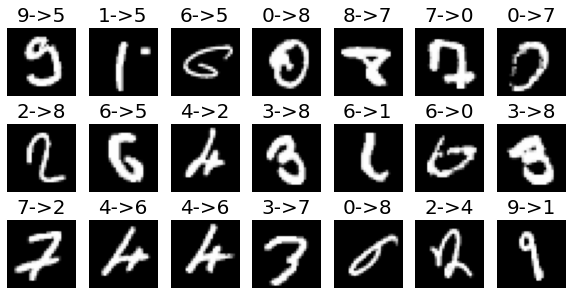

In [14]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}->{}'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

**Во многих случаях ошибки сети достаточно очевидны, числа написаны нечетко, неоднозначно**  

**Вообще говоря, здесь и человек не всегда поймет однозначно**  

**Предсказания, в основном показывают наиболее вероятный после правильного вариант**

### HW1 (1 балл): Реализовать Tanh

In [15]:
class Tanh:
    """
    Tanh(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x)) = 1 - 2/(exp(2x)+1)
    """
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.tanh = np.tanh(X)
        return self.tanh
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        
        return (1 - (self.tanh)**2) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.069/0.069	Accuracy: 0.980/0.979

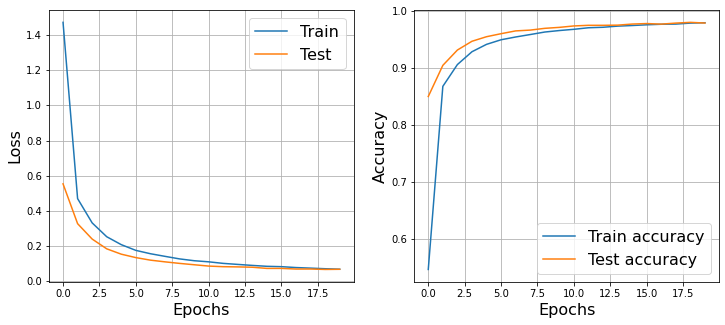

In [20]:
"""
Use Tanh as nonlinear function
"""
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [21]:
"""
Датасет без изменений
"""
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

**Небольшие вращения (-15, 15)**

In [39]:
"""
Сеть поставим c нелинейностью Sigmoid(), чтобы был виден вклад аугментаций
"""
network = NeuralNetwork([Linear(784, 100),  Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

In [40]:
transform_rotate = transforms.Compose([transforms.RandomAffine(degrees=15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081))])
train_dataset_rotate = MNIST('.', train=True, download=True, transform=transform_rotate)
test_dataset_rotate = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_rotate + train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_rotate, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.156/0.142	Accuracy: 0.957/0.961

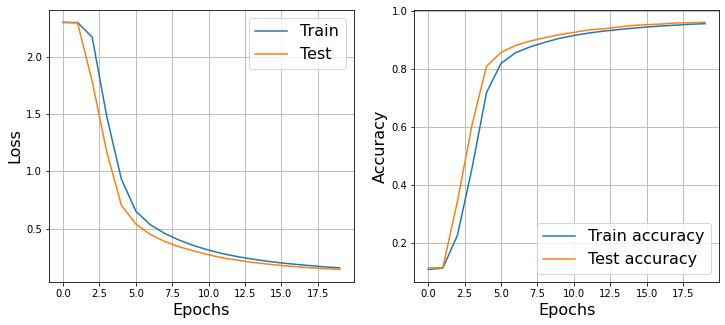

In [41]:
tr_rot_s, ts_rot_s, tr_ac_rot_s, ts_ac_rot_s = train(network, 20, 0.01, plot=True, verbose=True)

**Случайные сдвиги**

In [42]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

In [43]:
transform_shift = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

train_dataset_shift = MNIST('.', train=True, download=True, transform=transform_rotate)
test_dataset_shift = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_shift+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_shift, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.164/0.148	Accuracy: 0.954/0.961

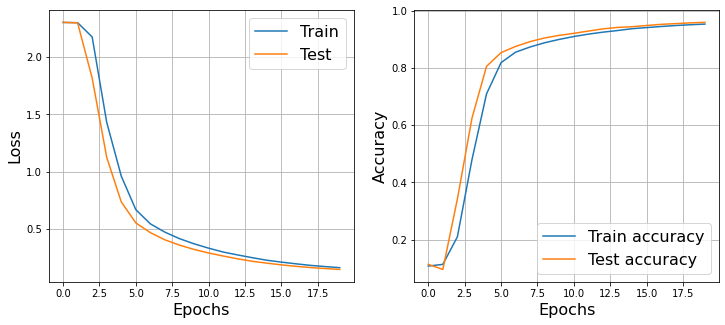

In [44]:
tr_sh_s, ts_sh_s, tr_ac_sh_s, ts_ac_sh_s = train(network, 20, 0.01, plot=True, verbose=True)

**Шум**

In [50]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

In [51]:
transform_noise = transforms.Compose([transforms.ToTensor(),
                                      transforms.Lambda(lambda x: x + 0.1*torch.randn_like(x)),
                                      transforms.Normalize((0.1307), (0.3081))])

train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_noise+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_noise, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.137/0.146	Accuracy: 0.963/0.959

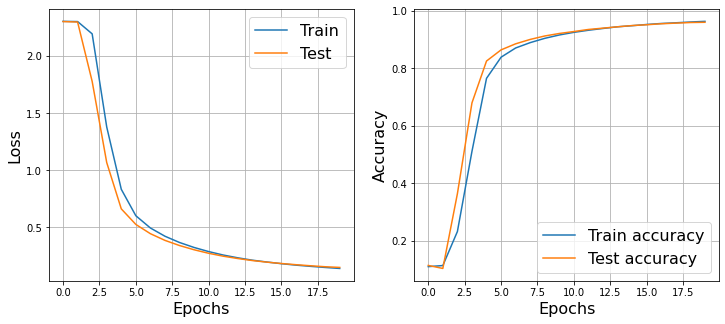

In [52]:
tr_n_s, ts_n_s, tr_ac_n_s, ts_ac_n_s = train(network, 20, 0.01, plot=True, verbose=True)

**Все аугментации**

In [74]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

In [75]:
transform_all = transforms.Compose([transforms.RandomAffine(15, (0.1, 0.1)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                                    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_all+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.261/0.138	Accuracy: 0.925/0.963

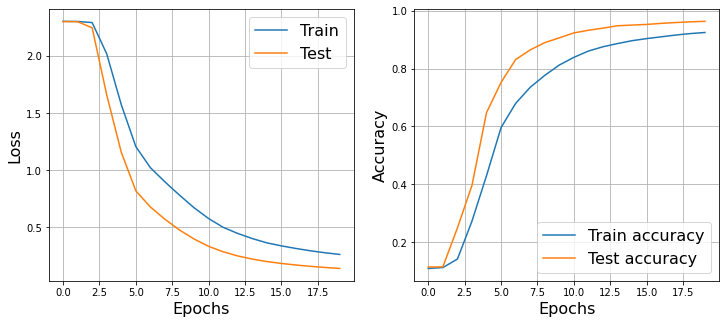

In [76]:
tr_all_s, ts_all_s, tr_ac_all_s, ts_ac_all_s = train(network, 20, 0.01, plot=True, verbose=True)

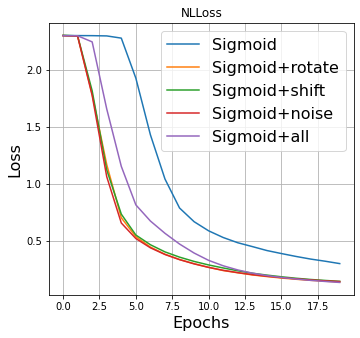

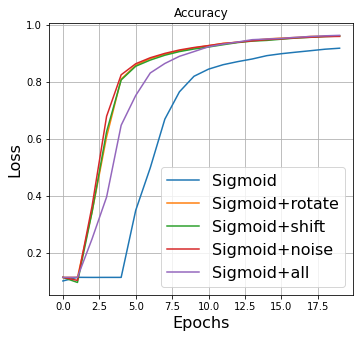

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('NLLoss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_rot_s, label='Sigmoid+rotate')
plt.plot(ts_sh_s, label='Sigmoid+shift')
plt.plot(ts_n_s, label='Sigmoid+noise')
plt.plot(ts_all_s, label='Sigmoid+all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_rot_s, label='Sigmoid+rotate')
plt.plot(ts_ac_sh_s, label='Sigmoid+shift')
plt.plot(ts_ac_n_s, label='Sigmoid+noise')
plt.plot(ts_ac_all_s, label='Sigmoid+all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

**Видим, что добавление данных с аугментаций значительно повышает скорость сходимсости сети**  

**Причем поворот/сдвиг/шум работают одинаково хорошо**  

**Если берем все аугментации, то результат получается лучше, но сходимость выравнивается (относительно отдельных) только к 10й эпохе**

**Далее обучим сеть с ReLU, ELU и Tanh со всеми аугментациями**

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Epoch 19... (Train/Test) NLL: 0.082/0.045	Accuracy: 0.975/0.986

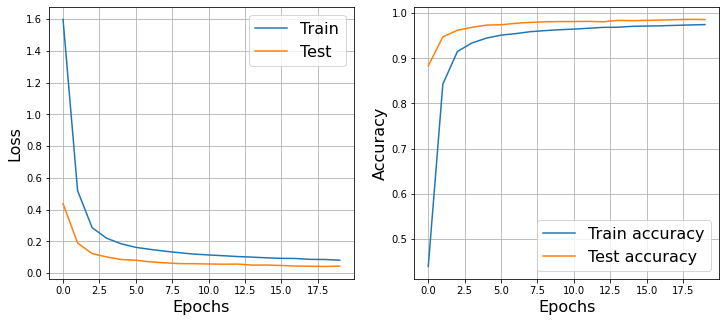

In [79]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

transform_all = transforms.Compose([transforms.RandomAffine(15, (0.1, 0.1)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                                    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_all+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=True)

tr_all_r, ts_all_r, tr_ac_all_r, ts_ac_all_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.085/0.048	Accuracy: 0.974/0.984

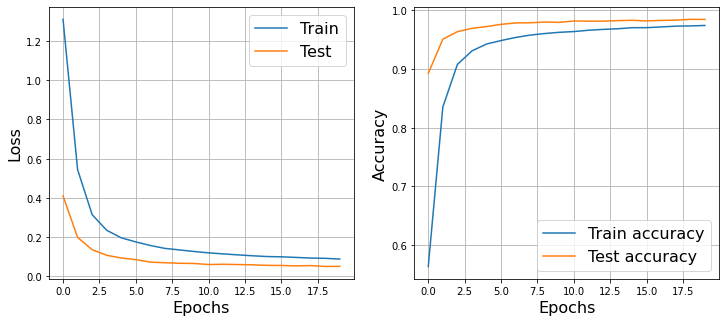

In [80]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()

transform_all = transforms.Compose([transforms.RandomAffine(15, (0.1, 0.1)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                                    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_all+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=True)

tr_all_e, ts_all_e, tr_ac_all_e, ts_ac_all_e = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.098/0.054	Accuracy: 0.970/0.984

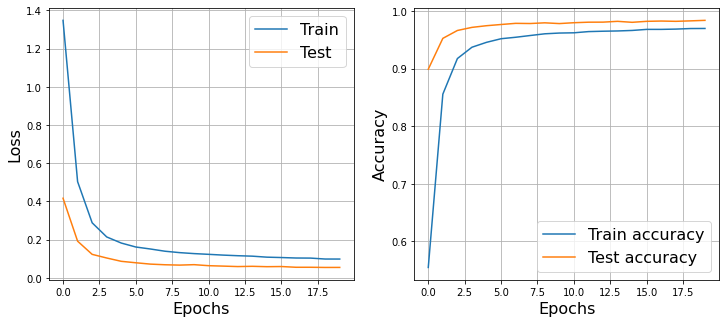

In [81]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

transform_all = transforms.Compose([transforms.RandomAffine(15, (0.1, 0.1)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                                    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset_all = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset_all = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset_all+train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=True)

tr_all_t, ts_all_t, tr_ac_all_t, ts_ac_all_t = train(network, 20, 0.01, plot=True, verbose=True)

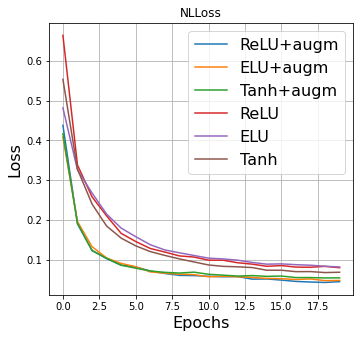

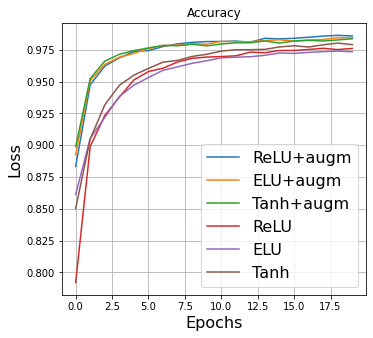

In [99]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('NLLoss')
plt.plot(ts_all_r, label='ReLU+augm')
plt.plot(ts_all_e, label='ELU+augm')
plt.plot(ts_all_t, label='Tanh+augm')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(ts_ac_all_r, label='ReLU+augm')
plt.plot(ts_ac_all_e, label='ELU+augm')
plt.plot(ts_ac_all_t, label='Tanh+augm')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

**Посмотрим как менялась сеть с самым маленьким accuracy и с самым большим**

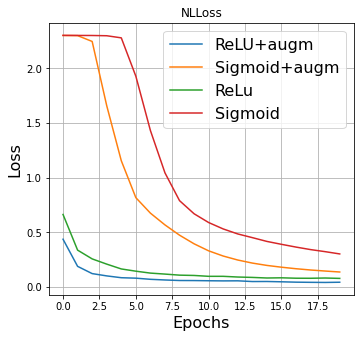

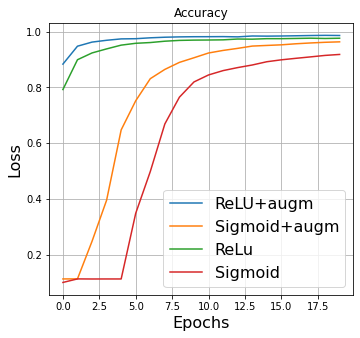

In [96]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('NLLoss')
plt.plot(ts_all_r, label='ReLU+augm')
plt.plot(ts_all_s, label='Sigmoid+augm')
plt.plot(ts_r, label='ReLu')
plt.plot(ts_s, label='Sigmoid')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(ts_ac_all_r, label='ReLU+augm')
plt.plot(ts_ac_all_s, label='Sigmoid+augm')
plt.plot(ts_ac_r, label='ReLu')
plt.plot(ts_ac_s, label='Sigmoid')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

- **По итогу видим, что аугментация повышает скорость обучения и качество для всех сетей с выбранными нелинейностями**  

- **На train результаты хуже, чем на test, т.к. данные для обучения разбавили шумом поворотами и сдвигами (тяжело в учении - ...)**  

- **Лучший результат показала функция активации ReLU- 0.986 за 20 эпох**  

- **Ярче всего результат аугментации виден на сети с сигмоидой**